# The Ising model

The Ising model describes a set of spins sitting on the sites
of a given lattice. We will consider the **periodic** two-dimensional square
lattice. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
neighbors on the lattice. In the following, we will consider the
ferromagnetic case $J>0$ and use $J=1$ as our unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## Computing average values

The general formula for the computation of the average value of a physical
observable $O$ is

$$
\langle O \rangle=\frac{1}{Z}\sum_{\{\sigma\}}O({\{\sigma\}}) \exp(-\beta E(\{\sigma\}))
\quad \mathrm{with} \quad
Z = \sum_{\{\sigma\}} \exp(-\beta E(\{\sigma\}))
$$

For instance the average total magnetization can be obtained from

$$
\langle M \rangle=\frac{1}{Z}\sum_{{\{\sigma\}}} \big[ \sum_i \sigma_i \big] \exp(-\beta E(\{\sigma\}))
$$

## Physical quantities of interest

In this notebook, we will be interested in computing some physical observables in order to
investigate the phase transition of the Ising model. The quantities are:

- The average energy $\langle E \rangle$


- The specific heat

$$
c_V=\frac{1}{N} \frac{\partial \langle E\rangle}{\partial T} =\frac{\beta^2}{N} \big( \langle E^2\rangle -\langle E \rangle^2 \big)
$$


- The average of the absolute value of the magnetization $\langle | M | \rangle$


- The corresponding magnetic susceptibility

$$
\chi = \frac{\beta}{N} \big( \langle M^2\rangle-\langle |M| \rangle^2 \big),
$$

The reason for using the absolute value of the magnetization rather than the
magnetization itself is related to some limitations of Monte Carlo simulations on
finite-size systems. Indeed, the system has a symmetry $\{ \sigma \} \to \{ -\sigma \}$
and therefore, on a finite system, a Monte Carlo simulation will visit these two
configurations with the same probability, leading to $\langle M \rangle = 0$. This makes
it difficult to extract useful information from the magnetization itself. Using the
absolute value instead, finite-size effect do not have such a dramatic effect and
one can prove that the critical exponents of this
modified magnetic susceptibility are the same as the original ones.

## Manipulating spin configurations

The goal of this first part is to find an easy way to encode a given spin configuration,
to visualize it and to compute some of its properties. But as always, let us first import
the necessary libraries

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### Generation and visulization

A possible way to encode a configuration is to use an $L \times L$ numpy
array. A random configuration can be obtained with
```python
L = 10
spin_configuration = np.random.choice([-1,1], size=(L,L))
```
This configuration can then be easily displayed with `plt.matshow(spin_configuration)`.

- Generate a random configuration and display it

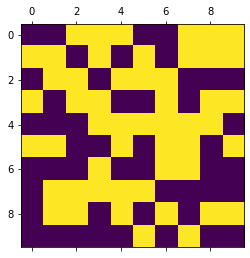

In [2]:
L = 10
spin_configuration = np.random.choice([-1,1], size=(L,L))
plt.matshow(spin_configuration)

### Energy and magnetization

- Write two functions that compute the energy and the magnetization of a given
  configuration. They can have a signature:
  ```python
  def compute_energy(config):
      # ...
      return energy
    
  def compute_magnetization(config):
      # ...
      return magnetization
  ```
  where `config` is the spin configuration given as a numpy array.

In [3]:
def compute_energy(config):
    pair_sum = 0
    for i in range(L):
        for j in range(L):
            pair_sum += config[i,j] * config[(i+1)%L,j] + config[i,j] * config[i,(j+1)%L]
    return -pair_sum
    
def compute_magnetization(config):
    return np.sum(config)

- Test the two functions by inspecting a random $3 \times 3$ configuration

Energy of the configuration:        2
Magnetization of the configuration: -1


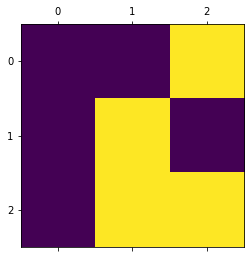

In [4]:
L = 3
spin_configuration = np.random.choice([-1,1], size=(L,L))
plt.matshow(spin_configuration)

print("Energy of the configuration:        {}".format(compute_energy(spin_configuration)))
print("Magnetization of the configuration: {}".format(compute_magnetization(spin_configuration)))

## Metropolis-Hastings algorithm with local spin flips

In the following, we will investigate several Monte Carlo algorithms that allow to sample
the spin configurations according to the Boltzmann distribution. They all satisfy the
detailed balance, but use different strategies. Here we start with the Metropolis-Hastings algorithm.
This algorithm follows these steps:

- Pick a random spin on the lattice and propose a flip

- Compute what would be the new Boltzmann weight $\pi(\mathrm{new})$ of the configuration

- Accepts this proposed configuration with probability

$$
  p^\mathrm{acc}_{\mathrm{old} \to \mathrm{new}} =
    \min \big( 1, \frac{\pi(\mathrm{new})}{\pi(\mathrm{old})} \big)
$$

- Note that in our case

$$
  \frac{\pi(\mathrm{new})}{\pi(\mathrm{old})} = \exp(-\beta (E_\mathrm{new} - E_\mathrm{old}))
  = \exp(-\beta \Delta E) = \exp(- 2 \beta h_{eff} \sigma_k)
$$

In order to obtain the energy difference $\Delta E$ it is not necessary to recompute the full
energy of the configuration, but only the modification due to the flip of the single spin.

### Metropolis-Hasting moves

- Write a function that will take a spin configuration and apply $L^2$ Metropolis-Hastings moves on it.
This function can have this structure:

```python
    def metropolis(config, T):
        
        # propose L^2 modifications
        L = config.shape[0]
        for k in range(L**2):
            
            # pick a random site
            i, j = np.random.randint(L, size=2)
            
            # compute the acceptance probability
            # accept or reject the move
            # ...
```

where `config` is the array with the spin configuration and `T` is the temperature.
The reason for doing $L^2$ proposals in a row is an empirical way to disentangle
the configuration before and after the Metropolis-Hastings move.

In [5]:
def metropolis(config, T, n_steps):

    # propose L^2 modifications
    L = config.shape[0]
    for k in range(n_steps):

        # pick a random site
        i, j = np.random.randint(L, size=2)
        
        # compute the acceptance probability
        h_eff = config[(i+1)%L,j] + config[(i-1)%L,j] + config[i,(j+1)%L] + config[i,(j-1)%L]
        acc_prob = np.exp(-2*h_eff*config[i,j] / T)
        
        # accept or reject the move
        if acc_prob > 1 or np.random.binomial(1, acc_prob):
            config[i,j] = -config[i,j]
    
    return config

### High versus low temperature behavior

- Starting from a random initial configuration, investigate how it evolves with successive
  Metropolis-Hastings steps. Compare this evolution for a low temperature $T=0.5$ and a
  high temperature $T=3$. You can use a lattice of size $50 \times 50$.

<IPython.core.display.Javascript object>


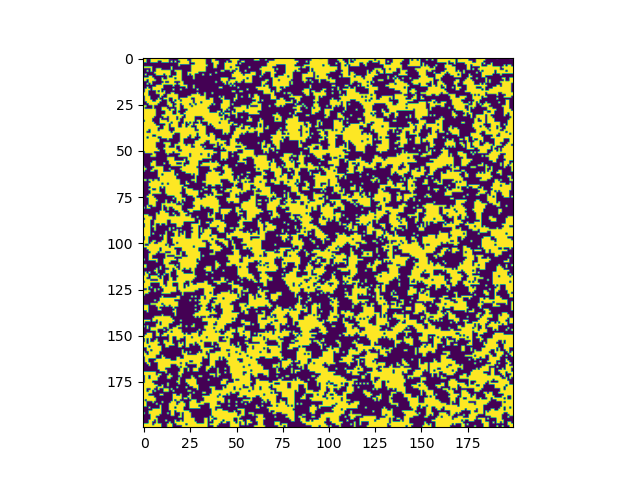

In [8]:
%matplotlib notebook

L = 200
T = 2.27
n_steps = 100

spin_configuration = np.random.choice([-1,1], size=(L,L))

fig = plt.figure()
im = plt.imshow(spin_configuration, animated=True)

def update(*args):
    global spin_configuration
    spin_configuration = metropolis(spin_configuration, T, n_steps)
    im.set_array(spin_configuration)
    return im,


ani = FuncAnimation(fig, update, frames=100, interval = 100, blit=True)

plt.show()

In [9]:
%matplotlib inline

### Compute physical observables

- Write a function that will run a Monte Carlo simulation and compute the average value
  of the 4 following observables normalized by the number of sites of the lattice
  $N = L^2$
  
  1. The average energy $\langle E \rangle \, / \, N$
  2. The specific heat $c_V \, / \, N$
  3. The average absolute magnetization $\langle | M | \rangle \, / \, N$
  4. The corresponding susceptibility $\chi \, / \, N$
  
  The function can have the following signature:
  ```python
    def monte_carlo(L, T, n_steps):
        # ...
        return energy, magnetization, cv, chi
  ```
  where `L` is the linear size of the lattice, `T` the temperature and `n_steps` the number
  of Monte Carlo steps.

- Run a simulation for 10 temperatures in the range $[0.5, 4]$. Use a lattice of size $6 \times 6$.
  If you want reasonably accurate results, you should make at least 5000 Monte Carlo steps. Note
  that at every Monte Carlo step there are $N = L^2$ proposals. Store the results in numpy arrays.
 

- Make 4 plots of the absolute magnetization, the energy, the susceptibility and the specific heat as a function of temperature.

## Heat bath algorithm

We now turn to the heat bath algorithm. The main difference with Metropolis-Hastings is that it is
rejection-free. Every proposal will be accepted. It satisfies the detailed balance

$$
\pi(a) p_{a \to b} = \pi(b) p_{b \to a}
$$

The algorithm picks a random spin and chooses its next value according to

$$
\pi_+ = \frac{1}{1 + e^{-2 \beta h}} \qquad
\pi_- = \frac{1}{1 + e^{2 \beta h}} \qquad
h = \sum_{i \in \text{neighbors of site}} \sigma_i
$$

where $h$ is the molecular field felt by the chosen site.

### Heat bath moves

- Write a function that will take a spin configuration and apply $L^2$ heat bath moves on it.
This function can have this structure:

```python
    def heat_bath(config, T):
        
        # make L^2 modifications
        L = config.shape[0]
        for k in range(L**2):
            
            # pick a random site
            i, j = np.random.randint(L, size=2)
            
            # flip chosen spin with heat bath probability
            # ...
            
```

where `config` is the array with the spin configuration and `T` is the temperature.

### Compute physical observables

- Run the same simulation as above for 10 temperatures in the range $[0.5, 4]$ but this
  time with the heat bath algorithm. Use a lattice of size $6 \times 6$.
  If you want reasonably accurate results, you should make at least 5000 Monte Carlo steps. Note
  that at every Monte Carlo step there are $N = L^2$ proposals. Store the results in numpy arrays.

- Make 4 plots of the absolute magnetization, the energy, the susceptibility and the specific heat as a function of temperature. Compare them with the ones obtained by the Metropolis-Hastings algorithm.

## Cluster algorithm

This last algorithm is again a rejection-free algorithm. But unlike the two algorithms above, it
will generate flips for multiple spins inside a cluster at the same time. The great advantage of
cluster algorithms is that they do not suffer from the same critical slowdown as single-spin-flip
algorithms do close to the phase transition.

In the Wolff cluster algorithm, we grow a cluster with the following procedure:

- Suppose we have already started constructing a cluster with all spins aligned

- Pick a site on the border of the cluster and identify its neighbors that are
  outside of the cluster
  
- If some of the neighbors are aligned with the spins in the cluster, include them
  in the cluster with probability
  
  $$p=1-\exp(-2\beta)$$
  
- Continue by picking the other spins on the border

- Proceed until the cluster stops growing

- Eventually flip all the spins in the cluster

At the very beginning, we start the construction of the cluster by choosing a random
site that forms an initial cluster of size 1.

### Wolff cluster moves

- Write a function that will take a spin configuration and apply the Wolff cluster move on it.
Note that in this case, we only perform a single cluster move because this generates
a new configuration which is already quite independent from the previous one.
This function can have this structure:


```python
def wolff(config, T):
    
    # pick a site
    i, j = np.random.randint(L, size=2)
    
    # grow the cluster
    # ...
    
    # flip all spins in the cluster
    # ...
```

### Compute physical observables

- Run the same simulation as above for 10 temperatures in the range $[0.5, 4]$ but this
  time with the Wolff cluster algorithm. Use a lattice of size $6 \times 6$.
  If you want reasonably accurate results, you should make at least 5000 Monte Carlo steps. Note
  that this time there is only a single cluster construction at every step. Store the results in numpy arrays.

- Make 4 plots of the absolute magnetization, the energy, the susceptibility and the specific heat as a function of temperature. Compare them with the ones obtained by the Metropolis-Hastings algorithm.

### Critical exponent for the susceptibility

Close to the transition, the magnetic susceptibility behaves as $\chi\propto |T-T_c|^{-1.75}$.
Observing critical behaviors require quite large lattices. We will use a $20 \times 20$
lattice here because we do not want the simulation to become too long. But better results
would be obtained on a larger lattice.

- Calculate the susceptibility at 10 equidistant points in the interval $[T_c+0.05,4]$
  and store it. You can use 20000 Monte Carlo steps. Note that this simulation takes a bit of
  time...

- Plot the result as a function of $T-T_c$ in a log-log plot. Compare it with the
  expected behavior $|T-T_c|^{-1.75}$. Comment the result.

### System size dependence

Phase transitions only exist for inifinite systems. On finite-size systems, physical quantities
do not diverge and only show some structure close to the critical temperature. Finding a precise
estimate of the critical temperature then requires to perform a finite-size scaling analysis.
We will not do that here, but it is still interesting to see how results depend on the lattice
size.

- Calculate the susceptibility $\chi$ for systems with linear sizes $L = 2, 4, 6, 8, 10, 12$
  for 10 temperatures in the range $[2, 3]$. You can use 5000 Monte Carlo steps.
  Plot the results together with a line showing the $T_c$ for the phase transition.
  Comment your results.